### Prova RMC

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import scipy as sci

import os
import pandas as pd
from ase.io import rmc6f
from ase.io import cfg
from ase.visualize import view
from ase.visualize import ngl


from ase import Atoms
from ase.neighborlist import NeighborList
import nglview as nv

from ase.neighborlist import neighbor_list


os.chdir('/home/simo/Scrivania/Thesis/RMC/RMCProfile/Simulations/Prova/350K/')


In [ ]:
def read_dat_file(filename,skip):
    data = np.loadtxt(filename+'.dat',skiprows= skip,encoding='unicode_escape') #utf-8-sig')
    col = []
    num = len(data.transpose())
    for i in range(num):
        if num == len(data):
            col1 = data[i]
        else:
            col1 = data[:,i]
        col.append(col1)
    return col


In [947]:
def check_RMC_simulation(filepath,directories,filename,which_plot,chi):

    if which_plot == 'gdr' or which_plot == 'both':
        r = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_PDF1.csv',header=1,usecols = [0], nrows = 611).values.flatten()
        gdr = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_PDF1.csv',header=1,usecols = [2], nrows = 611).values.flatten()
        plt.plot(r,gdr, label = 'Exp')

        for i in directories:

            gdr_rmc =  pd.read_csv(filepath+'/'+i+'/'+filename+'_PDF1.csv',header=1,usecols = [1], nrows = 611).values.flatten()

            plt.plot(r,gdr_rmc,label = 'RMC '+i)

            
        plt.legend()
        plt.xlabel(r'$r$ [$\AA$]')
        plt.ylabel(r'$G(r)$')
        plt.title('Radial distribution function')
        plt.show()


    if which_plot == 'sdq' or which_plot == 'both':
        q = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_SQ1.csv',header=1,usecols = [0], nrows = 611).values.flatten()
        sdq = pd.read_csv(filepath+'/'+directories[0]+'/'+filename+'_SQ1.csv',header=1,usecols = [2], nrows = 611).values.flatten()
        plt.plot(q,sdq, label = 'Exp')

        for i in directories:

            sdq_rmc =  pd.read_csv(filepath+'/'+i+'/'+filename+'_SQ1.csv',header=1,usecols = [1], nrows = 611).values.flatten()

            plt.plot(q,sdq_rmc,label = 'RMC '+i)

        
        plt.xlabel(r'$Q$ [$\AA^{-1}$]')
        plt.ylabel(r'$S(Q)$')
        plt.title('Structure factor')
        plt.legend()
        plt.show()

    for i in directories:
        data = np.loadtxt(filepath+'/'+i+'/'+filename+'.chi2', skiprows = 1 ).transpose()

        acc_moves = data[0]
        
        if np.size(chi)>1:
            chi2 = data[chi[0]]
        else:
            chi2 = data[chi]
        
        if np.size(chi2) > 1:
            plt.plot(acc_moves,chi2)
            plt.title('Chi squared '+i)
            plt.xlabel('Accepted moves')
            plt.ylabel(r'$\chi^2$')
            plt.yscale('log')
            if np.size(chi) > 1:
                plt.ylim(chi[1],chi[2])
            plt.show()
        else:
            continue


Function to compute the coordination number of one atomic species with another within a given distance shell

In [ ]:
def coordination_number_calculator(atoms, species1, species2, min_distance, max_distance):
    # Initialize variables
    individual_coordination_numbers = []
    total_coordination_number = 0
    species1_indices = [i for i, atom in enumerate(atoms) if atom.symbol == species1]
    species2_indices = [i for i, atom in enumerate(atoms) if atom.symbol == species2]

    # Create a neighbor list
    cutoffs = [max_distance / 2.0] * len(atoms)
    nl = NeighborList(cutoffs, self_interaction=False, bothways=True)
    nl.update(atoms)

    # Loop through each atom of species1
    for i in species1_indices:
        neighbors = nl.get_neighbors(i)[0]
        count = 0
        for neighbor in neighbors:
            if neighbor in species2_indices:
                distance = atoms.get_distance(i, neighbor)
                if min_distance <= distance <= max_distance:
                    count += 1
        individual_coordination_numbers.append(count)
        total_coordination_number += count

    # Calculate average coordination number
    average_coordination_number = total_coordination_number / len(species1_indices) if species1_indices else 0

    # Count the occurrences of each element in the array
    element_count = {}
    for num in individual_coordination_numbers:
        if num in element_count:
            element_count[num] += 1
        else:
            element_count[num] = 1

    # Calculate the percentage of each element
    total_elements = len(individual_coordination_numbers)
    percentage_dict = {num: (count / total_elements) * 100 for num, count in element_count.items()}

    # Sort the elements by their values (keys) from smallest to largest
    sorted_percentage = dict(sorted(percentage_dict.items()))

    # Printing the result
    print(f"Average coordination number {average_coordination_number:.2f}")
    for element, percentage in sorted_percentage.items():
        print(f"Coordination number {element:.0f}: {percentage:.2f}% ")

    #return individual_coordination_numbers, average_coordination_number


In [835]:
def coordination_number_calculator_pbc(atoms, species1, species2, min_distance, max_distance):
    # Initialize variables
    individual_coordination_numbers = []
    total_coordination_number = 0
    species1_indices = [i for i, atom in enumerate(atoms) if atom.symbol == species1]
    species2_indices = [i for i, atom in enumerate(atoms) if atom.symbol == species2]

    # Calculate the neighbor list with periodic boundary conditions
    i, j, distances = neighbor_list('ijd', atoms, cutoff=max_distance)

    # Filter pairs based on the specified elements and distance range
    valid_pairs = ((distances >= min_distance) & (distances <= max_distance) &
                   np.isin(i, species1_indices) & np.isin(j, species2_indices))
  
    # Count the number of valid pairs for each atom in species1_indices
    coordination_numbers = np.bincount(i[valid_pairs], minlength=len(atoms))

    # Collect coordination numbers for species1 atoms
    for idx in species1_indices:
        individual_coordination_numbers.append(coordination_numbers[idx])
        total_coordination_number += coordination_numbers[idx]

    # Calculate average coordination number
    average_coordination_number = total_coordination_number / len(species1_indices) if species1_indices else 0

    # Count the occurrences of each element in the array
    element_count = {}
    for num in individual_coordination_numbers:
        if num in element_count:
            element_count[num] += 1
        else:
            element_count[num] = 1

    # Calculate the percentage of each element
    total_elements = len(individual_coordination_numbers)
    percentage_dict = {num: (count / total_elements) * 100 for num, count in element_count.items()}

    # Sort the elements by their values (keys) from smallest to largest
    sorted_percentage = dict(sorted(percentage_dict.items()))

    # Printing the result
    print("Average "+species1+"-"+species2+f" coordination number {average_coordination_number:.2f}")
    for element, percentage in sorted_percentage.items():
        print(f"Coordination number {element:.0f}: {percentage:.2f}% ")

    # Return individual coordination numbers and average coordination number
    #return individual_coordination_numbers#, average_coordination_number

Function to add oxygen atoms in between Ge atoms distant in a certain window. if the Ge network construction is efficient, this is an easy way to build the GeO $_2$ network

In [ ]:
def add_oxygen_atoms(ge_atoms,min_distance,max_distance,filepath):  
    
    ge_positions = ge_atoms.get_positions()
    # List to store the positions of the O atoms to be inserted
    o_positions = []

    # Calculate the distances and find midpoints
    for i in range(len(ge_positions)):
        for j in range(i + 1, len(ge_positions)):
            # Calculate the distance between atom i and j
            distance = np.linalg.norm(ge_positions[i] - ge_positions[j])
            
            # Check if the distance is within the specified range
            if min_distance <= distance <= max_distance:
                # Calculate the midpoint
                midpoint = (ge_positions[i] + ge_positions[j]) / 2.0
                o_positions.append(midpoint)
    
    o_atoms = Atoms('O'*len(o_positions),positions=o_positions,cell=ge_atoms.get_cell())

    print('Number of O atoms added:',len(o_atoms.get_positions()))

    geo2_atoms = ge_atoms + o_atoms

    rmc6f.write_rmc6f(filepath+'/ge_o_network.rmc6f',atoms=geo2_atoms)

    return geo2_atoms


In [ ]:
def add_oxygen_atoms_pbc(ge_atoms, min_distance, max_distance, filepath):  
    ge_positions = ge_atoms.get_positions()
    cell = ge_atoms.get_cell()
    pbc = ge_atoms.get_pbc()
    o_positions_set = set()

    # Use neighbor_list to find pairs within the distance range
    i_list, j_list, distances = neighbor_list('ijd', ge_atoms, {('Ge', 'Ge'): max_distance})
    
    for i, j, distance in zip(i_list, j_list, distances):
        if min_distance <= distance <= max_distance and i < j:
            delta = ge_positions[i] - ge_positions[j]
            delta -= np.round(delta / cell.diagonal()) * cell.diagonal()
            midpoint = tuple(ge_positions[j] + 0.5 * delta)
            o_positions_set.add(midpoint)
    
    o_positions = list(o_positions_set)
    o_atoms = Atoms('O'*len(o_positions), positions=o_positions, cell=cell, pbc=pbc)
    print('Number of O atoms added:', len(o_atoms.get_positions()))

    geo2_atoms = ge_atoms + o_atoms
    rmc6f.write_rmc6f(filepath + '/ge_o_network.rmc6f', atoms=geo2_atoms)

    return geo2_atoms

In [ ]:
def check_configuration_building(filepath, directories):
    configurations = []
    for directory in directories:
        print('Configuration:', directory)
        
        # Traverse the directory tree
        for root, _, files in os.walk(os.path.join(filepath, directory)):
            print('Processing directory:', root)
            # Filter out the .rmc6f files that match the directory name
            rmc6f_files = [f for f in files if f.endswith(directory + '.rmc6f')]
          
            for rmc6f_file in rmc6f_files:
                print('Processing file:', rmc6f_file)
                atoms = rmc6f.read_rmc6f(os.path.join(root, rmc6f_file))
                configurations.append(atoms)
                print('Ge-Ge coordination')
                coordination_number_calculator(atoms, 'Ge', 'Ge', 0, 3.6)
                
                if directory == 'ge_o_network':
                    print('Ge-O coordination')
                    coordination_number_calculator(atoms, 'Ge', 'O', 0, 1.8)
                    print('O-Ge coordination')
                    coordination_number_calculator(atoms, 'O', 'Ge', 0, 1.8)

    return configurations

In [773]:
def check_configuration_building_pbc(filepath, directories):
    configurations = []
    for directory in directories:
        print('Configuration:', directory)
        
        # Traverse the directory tree
        for root, _, files in os.walk(os.path.join(filepath, directory)):
            print('Processing directory:', root)
            # Filter out the .rmc6f files that match the directory name
            rmc6f_files = [f for f in files if f.endswith(directory + '.rmc6f')]
          
            for rmc6f_file in rmc6f_files:
                print('Processing file:', rmc6f_file)
                atoms = rmc6f.read_rmc6f(os.path.join(root, rmc6f_file))
                configurations.append(atoms)
                print('Ge-Ge coordination')
                coordination_number_calculator_pbc(atoms, 'Ge', 'Ge', 0, 3.6)
                
                if directory == 'ge_o_network':
                    print('Ge-O coordination')
                    coordination_number_calculator_pbc(atoms, 'Ge', 'O', 0, 1.8)
                    print('O-Ge coordination')
                    coordination_number_calculator_pbc(atoms, 'O', 'Ge', 0, 1.8)

    return configurations

Function to rebin q data to have them equally spaced and propagate error

In [ ]:
def rebin(filepath,filename):
    data = read_dat_file(filepath+'/'+filename, skip=2)
    # Ensure the data and errors arrays are numpy arrays
    q = np.array(data[0])
    sdq = np.array(data[1])
    err_sdq = np.array(data[2])

    # Define new bin edges
    q_min = q.min()
    q_max = q.max()
    bin_width = q[1]-q[0]
    bin_edges = np.arange(q_min, q_max + bin_width, bin_width)
    num_bins = len(bin_edges) - 1
    
    q_new = []
    # Initialize arrays for rebinned data and errors
    rebinned_data = np.zeros(num_bins)
    rebinned_errors = np.zeros(num_bins)
    bin_counts = np.zeros(num_bins)

    # Aggregate data and errors within each bin
    for i in range(len(q)):
        bin_index = np.digitize(q[i], bin_edges) - 1
        if 0 <= bin_index < num_bins:
            rebinned_data[bin_index] += sdq[i]
            rebinned_errors[bin_index] += err_sdq[i]**2
            bin_counts[bin_index] += 1

    # Normalize by the number of counts in each bin
    for i in range(num_bins):
        q_new.append(q[0]+i*bin_width)
        if bin_counts[i] > 0:
            rebinned_data[i] /= bin_counts[i]
            rebinned_errors[i] = np.sqrt(rebinned_errors[i]) / bin_counts[i]

    file_to_open = filepath+'/'+filename+'_rebinned.dat'

    with open(file_to_open, 'w', encoding='utf-8') as f:
        #f.write('Q S(Q) err_S(Q) \n')
        f.write(str(len(q_new)) +'\n '+filename+'    rebinned \n')
        for i in range(len(q_new)):
            f.write('  ')
            f.write(str(q_new[i]))
            f.write('  ')
            f.write(str(rebinned_data[i]))
            f.write('  ')
            f.write(str(rebinned_errors[i]))
            f.write('\n')
        f.close()

# Compute densities and scattering factors

In [ ]:
### Compute neuron scattering coefficients

def lin_fit(x,a,b):
    return a*x+b

N = 6.022e23   #avogadro number

#GeO2


T = [350, 500, 600, 700, 750, 800, 850, 900, 1000,1400]  # K

T_data = [300, 1373] #K
density = [3.66, 3.465]  # g/cm^3

slope = (density[0]-density[1])/(T_data[0]-T_data[1])
intercept = (T_data[1]*density[0]-T_data[0]*density[1])/(T_data[1]-T_data[0])


density_geo2 = lin_fit(np.array(T),*[slope,intercept])

aw_ge = 72.63 #g/mol
aw_o = 15.9994 #g/mol
aw_geo2 = aw_ge + 2*aw_o #g/mol

w_ge = aw_ge/aw_geo2
w_o = 2*aw_o/aw_geo2

n_geo2 = density_geo2*N/aw_geo2*1e-24  # atoms/A^3

sigma_ge_coh = 8.42   # barn  1e-28 m^2
sigma_ge_inc = 0.18 
sigma_o_coh = 4.232

sigma_geo2_coh = sigma_ge_coh+2*sigma_o_coh


T_plot = np.linspace(min(T_data),max(T),10000)
plt.plot(T_data,density,'x',label = 'Data')
plt.plot(T[:],density_geo2[:],'o',label = 'Extrapolation at experimental T')
plt.plot(T_plot,lin_fit(T_plot,*[slope,intercept]), '-', label = 'Extrapolation')
plt.legend()
plt.grid()
plt.xlabel('Temperature T [K]')
plt.ylabel(r'Mass density [g/cm$^3$]')
plt.title(r'Extrapolation of mass density of GeO$_2$')
plt.show()



In [ ]:
c_ge = 1/3
c_o = 2/3

neutron_coeff = [c_ge*c_ge*sigma_ge_coh/(4*np.pi),2*c_ge*c_o*np.sqrt(sigma_ge_coh*sigma_o_coh)/(4*np.pi),c_o*c_o*sigma_o_coh/(4*np.pi)]  # in barn

print(neutron_coeff)

In [ ]:
(c_ge*np.sqrt(sigma_ge_coh)+c_o*np.sqrt(sigma_o_coh))**2/(np.pi*4)

# Build initial configuration

Follow RMCA SiO $_2$ tutorial:  
* Build initial random configuration of Ge atoms, with minimum ditance approach. I set $d_{min} = 2.9 \AA$ form check on $g_{Ge-Ge}(r)$ in test runs.  
* Make a Ge-Ge net 4-fold coordinated, set minimum and also maximum distance between atoms, the latter is set to $d_{max}=3.6 \AA$, still form $g_{Ge-Ge}(r)$ in test runs.  
* Finally add O atoms in the middle point between Ge atoms. If the net is built correctly this is an easy task with the *add_oxygen_atoms* function.  
If this procedure is implemented correctly one obtains an initial configuration which is able to produce convergent results in a RMCProfile simulation, as previously observed with SiO $_2$.

### rand


In [ ]:
filepath = 'correct_sisi_coordination/rand/'

ge_atoms = rmc6f.read_rmc6f(filepath+'ge_rand.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 2.9, 3.6)

### net


In [ ]:

filepath = 'correct_sisi_coordination/net/30_min/'

ge_atoms = rmc6f.read_rmc6f(filepath+'ge_net.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Run another 30 minutes

In [ ]:
filepath = 'correct_sisi_coordination/net/30_min+30_min/'

ge_atoms = rmc6f.read_rmc6f(filepath+'ge_net.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Try with coord constraint 4, it should be 5, but still problems above

In [ ]:
filepath = 'correct_sisi_coordination/net_coord4/'

ge_atoms = rmc6f.read_rmc6f(filepath+'ge_net.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 0, 3.6)

In [ ]:
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

In [ ]:
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms, 2.9, 3.6, filepath)

In [ ]:
view(geo2_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 0, 1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 0, 1.8)

Use just dwindow constraints $[2.9 \AA,3.6 \AA]$

In [ ]:
filepath = 'correct_sisi_coordination/net_dw/'

ge_atoms = rmc6f.read_rmc6f(filepath+'ge_net.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Use just dwindow constraints $[2.9 \AA,3.6 \AA]$ + minimum_distances $2.9 \AA$

In [ ]:
filepath = 'correct_sisi_coordination/net_dw_mindist/'

ge_atoms = rmc6f.read_rmc6f(filepath+'ge_net.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 0, 3.6)

### add O atoms

In [ ]:
min_distance = 2.9
max_distance = 3.6
geo2_atoms = add_oxygen_atoms(ge_atoms,min_distance,max_distance,filepath)

In [ ]:
view(geo2_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(geo2_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator(geo2_atoms, 'O', 'Ge', 0,1.8)

### Simulation

In [ ]:
filepath = 'correct_sisi_coordination/ge_o_network'
directories = ['start','60_min']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,[5,1e1,1e3])

In [ ]:
filepath = 'correct_sisi_coordination/ge_o_network_coord4'
directories = ['30_min','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,5)

# Prova con 1000 Ge

In [ ]:
filepath= 'correct_coordination_1000atoms'
directories= ['rand','net']
config = check_configuration_building(filepath,directories)

In [ ]:
print('rand')
view(config[0],viewer = 'x3d')

In [ ]:
print('net')
view(config[1],viewer = 'x3d')

### add O atoms

In [ ]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = config[1]
geo2_atoms = add_oxygen_atoms(ge_atoms,min_distance,max_distance,filepath)

In [ ]:
view(geo2_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(geo2_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator(geo2_atoms, 'O', 'Ge', 0,1.17)
coordination_number_calculator(geo2_atoms, 'O', 'O', 0,3.5)

### simulation

In [ ]:
filepath = 'correct_coordination_1000atoms/ge_o_network'
directories = ['30_min','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,3)

# Prova con 2000 Ge

In [ ]:
filepath = 'correct_coordination_2000atoms/'
directories = ['rand','net']
config = check_configuration_building(filepath,directories)

In [ ]:
coordination_number_calculator_pbc(config[1], 'Ge', 'Ge', 0, 3.6)

In [ ]:
print('rand')  
view(config[0],viewer = 'x3d')

In [ ]:
print('net')
#view(config[1],viewer = 'x3d')

### add O atoms

In [ ]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = config[1]
geo2_atoms = add_oxygen_atoms(ge_atoms,min_distance,max_distance,filepath)

In [ ]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = config[1]
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms,min_distance,max_distance,filepath)

In [ ]:
view(geo2_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,1)

In [ ]:
filepath = 'correct_coordination_2000atoms/ge_o_network'
directories = ['30_min+30_min','30_min','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,[3,1e5,1e6])

In [ ]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/30_min/ge_o_network.rmc6f')

view(ge_atoms,viewer = 'x3d')

In [ ]:
coordination_number_calculator(ge_atoms, 'Ge', 'Ge', 2.9, 3.6)
coordination_number_calculator(ge_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator(ge_atoms, 'O', 'Ge', 0,1.8)

# PBC

In [ ]:
filepath = 'pbc_rulez'
directories = ['rand','net']
config = check_configuration_building_pbc(filepath,directories)

In [ ]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = config[1]
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms,min_distance,max_distance,filepath)

In [ ]:
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,1.4)

In [ ]:
filepath = 'pbc_rulez/ge_o_network'
directories = ['30_min','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,[4,1e2,1e3])

In [ ]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/30_min/ge_o_network.rmc6f')
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 1.17,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 1.17,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,3.2)
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'Ge', 0,3.6)

In [ ]:
filepath = 'pbc_rulez/ge_o_network_dw'
directories = ['30_min','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,[3,1e3,1e4])

In [ ]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/30_min/ge_o_network.rmc6f')
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,3)

# PBC 2000 atoms

In [600]:
filepath = 'pbc_rulez_2000'
directories = ['rand','net']
config = check_configuration_building_pbc(filepath,directories)

Configuration: rand
Processing directory: pbc_rulez_2000/rand
Processing file: ge_rand.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.17
Coordination number 0: 1.60% 
Coordination number 1: 8.15% 
Coordination number 2: 21.40% 
Coordination number 3: 30.35% 
Coordination number 4: 22.60% 
Coordination number 5: 11.05% 
Coordination number 6: 4.20% 
Coordination number 7: 0.65% 
Configuration: net
Processing directory: pbc_rulez_2000/net
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.95
Coordination number 1: 0.55% 
Coordination number 2: 1.85% 
Coordination number 4: 97.35% 
Coordination number 6: 0.05% 
Coordination number 7: 0.15% 
Coordination number 8: 0.05% 


In [ ]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = config[1]
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms,min_distance,max_distance,filepath)

In [ ]:
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 0,1.8)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,1.5)

In [ ]:
filepath = 'pbc_rulez_2000/ge_o_network/start'
filename = 'geo2_350K_sdq'
rebin(filepath,filename)

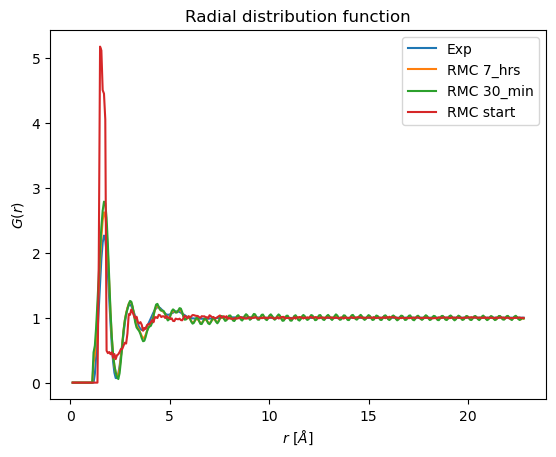

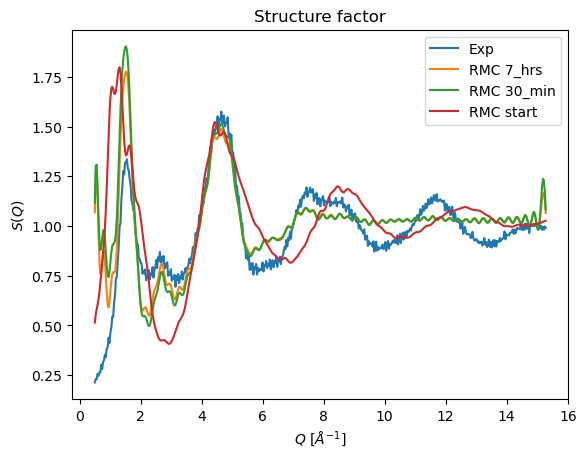

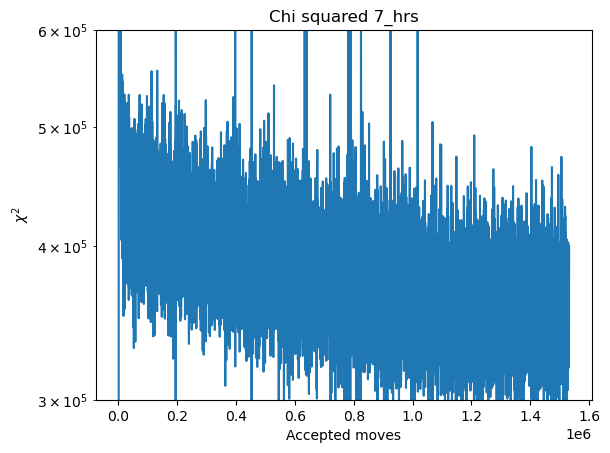

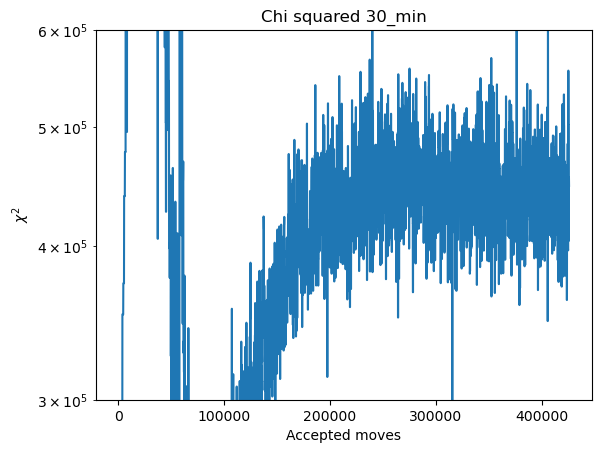

In [980]:
filepath = 'pbc_rulez_2000/ge_o_network'
#directories = ['10_min+10_min_gdr','7_hrs_gdr']
directories = ['7_hrs','30_min','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[5,3e5,6e5])

In [542]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/7_hrs/ge_o_network.rmc6f')
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,3)

Average Ge-O coordination number 3.96
Coordination number 1: 0.55% 
Coordination number 2: 1.90% 
Coordination number 3: 0.10% 
Coordination number 4: 96.55% 
Coordination number 5: 0.60% 
Coordination number 6: 0.20% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average O-Ge coordination number 2.00
Coordination number 2: 99.70% 
Coordination number 3: 0.30% 
Average O-O coordination number 4.46
Coordination number 0: 0.23% 
Coordination number 1: 1.54% 
Coordination number 2: 6.71% 
Coordination number 3: 16.95% 
Coordination number 4: 25.46% 
Coordination number 5: 26.06% 
Coordination number 6: 15.31% 
Coordination number 7: 5.74% 
Coordination number 8: 1.57% 
Coordination number 9: 0.40% 
Coordination number 10: 0.03% 


### $D(r)$ and $F(Q)$

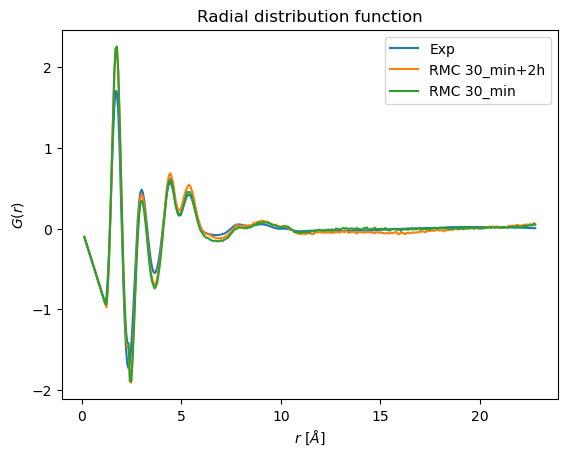

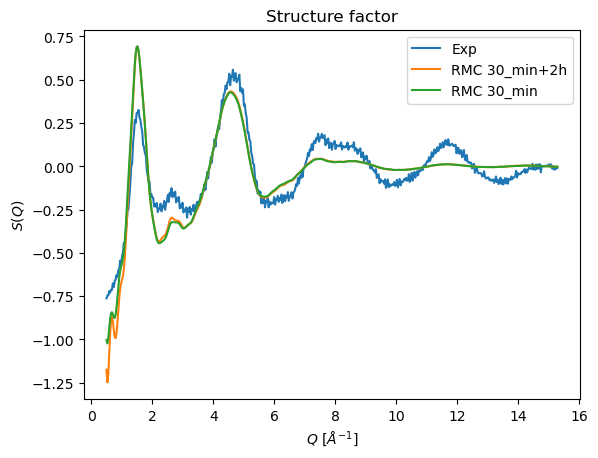

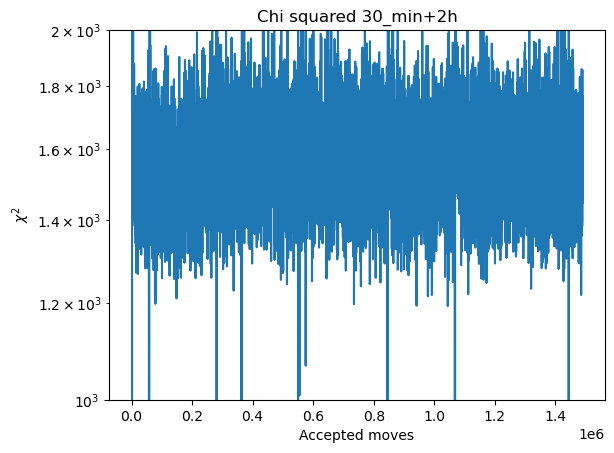

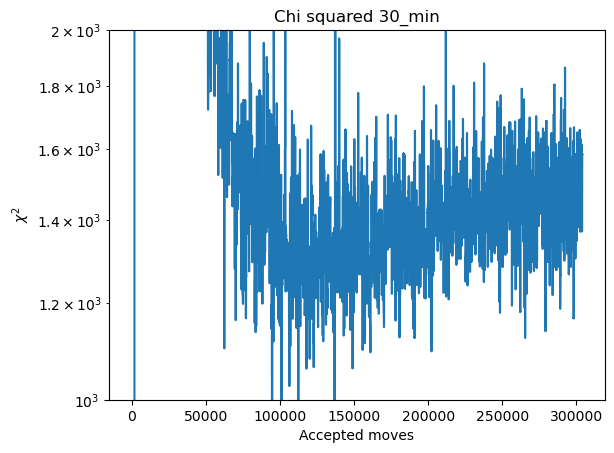

In [594]:
filepath = 'pbc_rulez_2000/ge_o_network/Dr_Fq'
directories = ['30_min+2h','30_min']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[5,1e3,2e3])

In [586]:
geo2_atoms = rmc6f.read_rmc6f(filepath+'/30_min/ge_o_network.rmc6f')
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 1.17,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'O', 0,3)


Average Ge-O coordination number 3.95
Coordination number 1: 0.55% 
Coordination number 2: 1.90% 
Coordination number 3: 0.10% 
Coordination number 4: 97.10% 
Coordination number 5: 0.05% 
Coordination number 6: 0.20% 
Coordination number 7: 0.05% 
Coordination number 8: 0.05% 
Average O-Ge coordination number 2.00
Coordination number 2: 99.97% 
Coordination number 3: 0.03% 
Average O-O coordination number 4.12
Coordination number 0: 0.25% 
Coordination number 1: 1.47% 
Coordination number 2: 7.54% 
Coordination number 3: 20.75% 
Coordination number 4: 31.60% 
Coordination number 5: 25.86% 
Coordination number 6: 10.27% 
Coordination number 7: 2.10% 
Coordination number 8: 0.13% 
Coordination number 9: 0.03% 


# PBC 7000

In [599]:
filepath= 'pbc_rulez_7000'
directories= ['rand','net']
config = check_configuration_building_pbc(filepath,directories)

Configuration: rand
Processing directory: pbc_rulez_7000/rand
Processing file: ge_rand.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.10
Coordination number 0: 1.16% 
Coordination number 1: 9.00% 
Coordination number 2: 22.51% 
Coordination number 3: 31.04% 
Coordination number 4: 22.06% 
Coordination number 5: 10.87% 
Coordination number 6: 2.84% 
Coordination number 7: 0.46% 
Coordination number 8: 0.06% 
Configuration: net
Processing directory: pbc_rulez_7000/net
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.89
Coordination number 0: 0.26% 
Coordination number 1: 1.63% 
Coordination number 2: 3.19% 
Coordination number 3: 1.20% 
Coordination number 4: 92.51% 
Coordination number 5: 0.56% 
Coordination number 6: 0.44% 
Coordination number 7: 0.19% 
Coordination number 8: 0.03% 


# PBC 1350

In [605]:
filepath= 'pbc_rulez_1350'
directories= ['rand','net']
config = check_configuration_building_pbc(filepath,directories)

Configuration: rand
Processing directory: pbc_rulez_1350/rand
Processing file: ge_rand.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.06
Coordination number 0: 1.78% 
Coordination number 1: 10.30% 
Coordination number 2: 22.89% 
Coordination number 3: 28.30% 
Coordination number 4: 22.37% 
Coordination number 5: 10.81% 
Coordination number 6: 3.11% 
Coordination number 7: 0.37% 
Coordination number 8: 0.07% 
Configuration: net
Processing directory: pbc_rulez_1350/net
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.97
Coordination number 0: 0.07% 
Coordination number 1: 0.59% 
Coordination number 2: 0.74% 
Coordination number 4: 98.52% 
Coordination number 6: 0.07% 


# PBC 700

In [903]:
def calculate_coordination_numbers(atoms, min_distance, max_distance):
    """Calculate coordination numbers for each atom."""
    i, j, distances = neighbor_list('ijd', atoms, cutoff=max_distance)
    valid_pairs = (distances >= min_distance) & (distances <= max_distance)
    coordination_numbers = np.bincount(i[valid_pairs], minlength=len(atoms))
    return coordination_numbers

def calculate_coordination_number_for_atom(atoms, atom_idx, min_distance, max_distance):
    """Calculate the coordination number for a single atom within a specified distance range."""
    i, j, distances = neighbor_list('ijd', atoms, cutoff=max_distance)
    valid_pairs = (distances >= min_distance) & (distances <= max_distance)
    
    # Filter pairs to include only those involving the specified atom
    valid_pairs_for_atom = valid_pairs & (i == atom_idx)
    
    # Count the number of valid neighbors for the specified atom
    coordination_number = np.sum(valid_pairs_for_atom)
    
    return coordination_number

def minimum_image_distance(pos1, pos2, cell):
    """Calculate the minimum image distance between two positions considering periodic boundary conditions."""
    delta = pos1 - pos2
    delta -= np.round(delta / cell) * cell
    return np.linalg.norm(delta, axis=-1)

def random_position_within_shell_and_outside_spheres(center, min_dist, max_dist, other_positions, exclusion_radius, cell):
    """Generate a random position within a spherical shell and outside other spheres considering periodic boundary conditions."""
    for _ in range(1000):  # Try up to 100 times to find a valid position
        random_direction = np.random.normal(size=3)
        random_direction /= np.linalg.norm(random_direction)  # Normalize direction
        random_distance = np.random.uniform(min_dist, max_dist)
        random_position = center + random_direction * random_distance
        random_position %= cell  # Apply periodic boundary conditions
        
        # Check if the new position is outside exclusion spheres
        distances = minimum_image_distance(random_position, np.array(other_positions), cell)
        #print number of delements in distances which are greater than exclusion_radius
        print(np.sum(distances >= exclusion_radius),len(other_positions))
        
        if np.all(distances >= exclusion_radius):
            return random_position
    return None

def move_atoms_over(atoms, coordination_numbers, target_coordination, min_dist, max_dist):
    """Move over-coordinated atoms closer to under-coordinated atoms within a radial distance window without disrupting other atoms."""
    high_coord_atoms = [i for i, cn in enumerate(coordination_numbers) if cn > target_coordination]
    low_coord_atoms = [i for i, cn in enumerate(coordination_numbers) if cn < target_coordination]
    cell = atoms.get_cell().diagonal()
    print(f"High coordination atoms: {high_coord_atoms}")
    print(f"Low coordination atoms: {low_coord_atoms}")

    for high_idx in high_coord_atoms:
        high_atom_pos = atoms.positions[high_idx]
        
        # Sort low_coord_atoms by their coordination numbers
        sorted_low_coord_atoms = sorted(low_coord_atoms, key=lambda idx: coordination_numbers[idx])
        
        for lowest_coord_idx in sorted_low_coord_atoms:
            nearest_low_pos = atoms.positions[lowest_coord_idx]
            print(f"Trying to move atom {high_idx} with coordination number {coordination_numbers[high_idx]} near to atom {lowest_coord_idx} with coordination number {coordination_numbers[lowest_coord_idx]}")
            
            # Collect positions of all other atoms
            other_positions = [atoms.positions[i] for i in range(len(atoms)) if i != high_idx and i != lowest_coord_idx]
            
            # Try to find a valid new position
            new_position = random_position_within_shell_and_outside_spheres(nearest_low_pos, min_dist, max_dist, other_positions, max_dist, cell)
            print(new_position)
            if new_position is not None:
                atoms.positions[high_idx] = new_position
                print(f"New position: {new_position}")
                break  # Exit the loop once a valid position is found
        else:
            print(f"Could not find a valid new position for atom {high_idx}")

def move_atoms_under(atoms, coordination_numbers, target_coordination, min_dist, max_dist):
    """Move under-coordinated atoms with fewer neighbors closer to under-coordinated atoms with more neighbors within a radial distance window without disrupting other atoms."""
    low_coord_atoms = [i for i, cn in enumerate(coordination_numbers) if cn < target_coordination]
    cell = atoms.get_cell().diagonal()
    print(f"Low coordination atoms: {low_coord_atoms}")

    # Sort low_coord_atoms by their coordination numbers in ascending order
    sorted_low_coord_atoms = sorted(low_coord_atoms, key=lambda idx: coordination_numbers[idx])

    for low_idx in sorted_low_coord_atoms:
        low_atom_pos = atoms.positions[low_idx]
        
        # Find the next under-coordinated atom with more neighbors
        for higher_idx in sorted_low_coord_atoms:
            if coordination_numbers[higher_idx] > coordination_numbers[low_idx]:
                higher_atom_pos = atoms.positions[higher_idx]
                print(f"Trying to move atom {low_idx} with coordination number {coordination_numbers[low_idx]} near to atom {higher_idx} with coordination number {coordination_numbers[higher_idx]}")
                
                # Collect positions of all other atoms
                other_positions = [atoms.positions[i] for i in range(len(atoms)) if i != low_idx and i != higher_idx]
                
                # Try to find a valid new position
                new_position = random_position_within_shell_and_outside_spheres(higher_atom_pos, min_dist, max_dist, other_positions, max_dist, cell)
                
                if new_position is not None:
                    atoms.positions[low_idx] = new_position
                    print(f"New position: {new_position}")
                    
                    # Update coordination numbers
                    
                    coordination_numbers[low_idx] = calculate_coordination_number_for_atom(atoms, low_idx, min_dist, max_dist)
                    coordination_numbers[higher_idx] = calculate_coordination_number_for_atom(atoms, higher_idx, min_dist, max_dist)
                    
                    # Check if either atom has obtained the right coordination
                    if coordination_numbers[low_idx] >= target_coordination or coordination_numbers[higher_idx] >= target_coordination:
                        print(f"Atom {low_idx} or atom {higher_idx} has obtained the right coordination: {coordination_numbers[low_idx]}, {coordination_numbers[higher_idx]}")
                        break  # Exit the loop once either atom has the right coordination
        else:
            print(f"Could not find a valid new position for atom {low_idx}")

In [830]:
filepath= 'pbc_rulez_700' 
directories= ['rand','net']
config = check_configuration_building_pbc(filepath,directories)

Configuration: rand
Processing directory: pbc_rulez_700/rand
Processing file: ge_rand.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.11
Coordination number 0: 1.43% 
Coordination number 1: 9.71% 
Coordination number 2: 22.57% 
Coordination number 3: 28.14% 
Coordination number 4: 23.57% 
Coordination number 5: 10.86% 
Coordination number 6: 3.29% 
Coordination number 7: 0.43% 
Configuration: net
Processing directory: pbc_rulez_700/net
Processing file: ge_net.rmc6f
Ge-Ge coordination
Average Ge-Ge coordination number 3.97
Coordination number 1: 0.29% 
Coordination number 2: 1.00% 
Coordination number 4: 98.57% 
Coordination number 6: 0.14% 


In [833]:
coordination_number = calculate_coordination_numbers(config[1], 2.9, 3.6)
move_atoms_over(config[1], coordination_number, 4, 2.9, 3.6)
coord0=coordination_number_calculator_pbc(config[1], 'Ge', 'Ge', 0, 3.6)
coord29=coordination_number_calculator_pbc(config[1], 'Ge', 'Ge', 2.9, 3.6)

rmc6f.write_rmc6f(filepath+'/ge_net_move.rmc6f',atoms=config[1])


High coordination atoms: []
Low coordination atoms: [36, 83, 89, 104, 134, 165, 276, 335, 336, 339, 352, 412, 437, 503, 603, 625]
Average Ge-Ge coordination number 3.96
Coordination number 1: 0.43% 
Coordination number 2: 0.86% 
Coordination number 3: 1.00% 
Coordination number 4: 97.71% 
Average Ge-Ge coordination number 3.96
Coordination number 1: 0.43% 
Coordination number 2: 0.86% 
Coordination number 3: 1.00% 
Coordination number 4: 97.71% 


In [832]:
0.43*7

3.01

In [748]:
print(0.86*7,98.57*7,97.57*7,97.43*7)

6.02 689.99 682.99 682.01


In [739]:
coordination_number = calculate_coordination_numbers(config[1], 2.9, 3.6)
move_atoms_over(config[1], coordination_number, 4, 2.9, 3.6)
coordination_number_calculator_pbc(config[1], 'Ge', 'Ge', 0, 3.6)

High coordination atoms: [97, 186, 240]
Low coordination atoms: [36, 83, 89, 104, 134, 165, 276, 335, 336, 339, 412, 437, 503, 603, 625]
Moving atom 97 with coordination number 5 near to atom 625 with coordination number 1
Moving atom 186 with coordination number 5 near to atom 625 with coordination number 1
Moving atom 240 with coordination number 5 near to atom 625 with coordination number 1
Average Ge-Ge coordination number 3.97
Coordination number 1: 0.14% 
Coordination number 2: 1.14% 
Coordination number 3: 0.86% 
Coordination number 4: 97.14% 
Coordination number 5: 0.71% 


In [848]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move/ge_net.rmc6f')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Average Ge-Ge coordination number 3.98
Coordination number 1: 0.29% 
Coordination number 2: 0.43% 
Coordination number 4: 99.29% 


In [849]:
ge_atoms_move_under = ge_atoms.copy()
coordination_number = calculate_coordination_numbers(ge_atoms_move_under, 2.9, 3.6)
move_atoms_under(ge_atoms_move_under, coordination_number, 4, 2.9, 3.6)
coordination_number_calculator_pbc(ge_atoms_move_under, 'Ge', 'Ge', 0, 3.6)

Low coordination atoms: [224, 339, 503, 603, 625]
Trying to move atom 503 with coordination number 1 near to atom 224 with coordination number 2
694 698
695 698
693 698
695 698
694 698
695 698
695 698
694 698
695 698
693 698
693 698
695 698
696 698
695 698
693 698
694 698
693 698
695 698
695 698
695 698
694 698
695 698
694 698
695 698
695 698
695 698
696 698
694 698
693 698
696 698
695 698
696 698
695 698
696 698
696 698
694 698
695 698
696 698
693 698
693 698
695 698
694 698
695 698
694 698
694 698
694 698
694 698
693 698
695 698
695 698
695 698
693 698
695 698
695 698
696 698
695 698
694 698
694 698
694 698
694 698
695 698
695 698
695 698
694 698
693 698
696 698
695 698
695 698
695 698
693 698
694 698
695 698
695 698
694 698
694 698
695 698
691 698
694 698
696 698
693 698
695 698
694 698
694 698
694 698
695 698
694 698
695 698
695 698
695 698
693 698
693 698
694 698
694 698
694 698
695 698
693 698
694 698
694 698
694 698
696 698
693 698
696 698
694 698
696 698
694 698
696 698
694 698

In [850]:
rmc6f.write_rmc6f(filepath+'/ge_net_move_under.rmc6f',atoms=ge_atoms_move_under)

In [857]:
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move_under/ge_net.rmc6f')
coordination_number_calculator_pbc(ge_atoms, 'Ge', 'Ge', 0, 3.6)

Average Ge-Ge coordination number 3.99
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 99.71% 


In [858]:
min_distance = 2.9
max_distance = 3.6
ge_atoms = rmc6f.read_rmc6f(filepath+'/net/move_under/ge_net.rmc6f')
geo2_atoms = add_oxygen_atoms_pbc(ge_atoms,min_distance,max_distance,filepath)

Number of O atoms added: 1398


In [862]:
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 0,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'O', 'Ge', 0,2.35)
coordination_number_calculator_pbc(geo2_atoms, 'Ge', 'O', 2.35,2.6)

Average Ge-O coordination number 4.00
Coordination number 1: 0.14% 
Coordination number 3: 0.14% 
Coordination number 4: 99.43% 
Coordination number 5: 0.29% 
Average O-Ge coordination number 2.00
Coordination number 2: 99.86% 
Coordination number 3: 0.14% 
Average Ge-O coordination number 0.11
Coordination number 0: 90.29% 
Coordination number 1: 8.86% 
Coordination number 2: 0.86% 


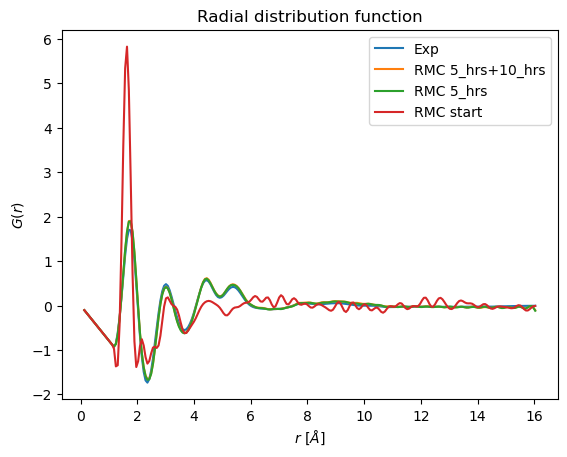

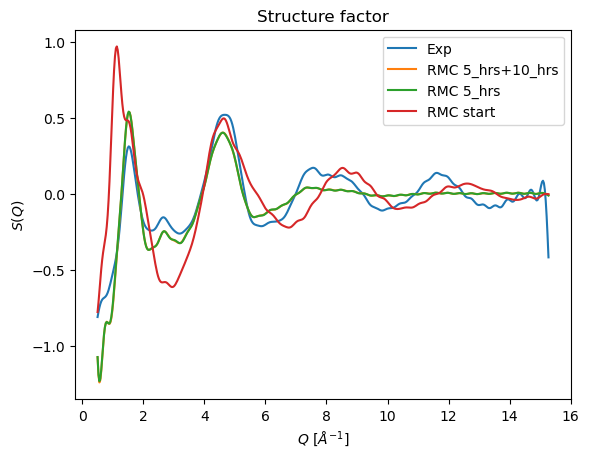

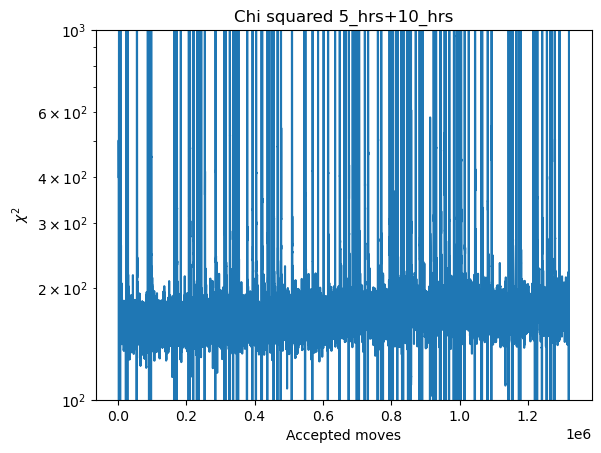

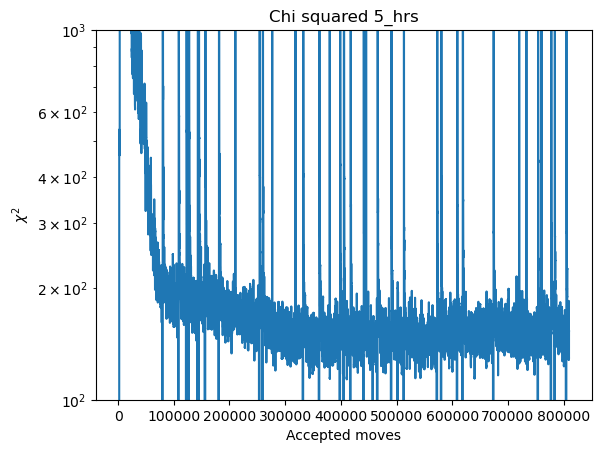

In [937]:
filepath = 'pbc_rulez_700/ge_o_network/dw'
directories = ['5_hrs+10_hrs','5_hrs','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[4,1e2,1e3])

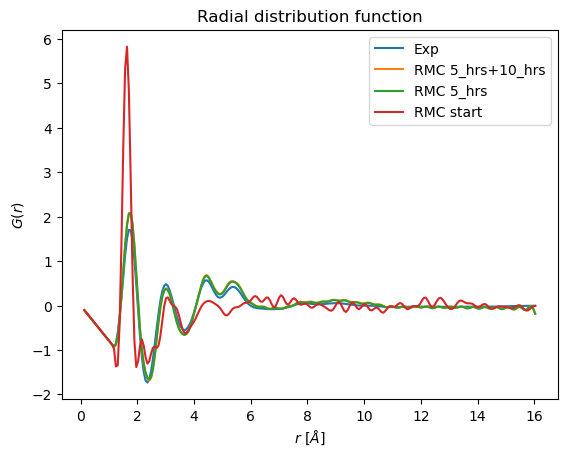

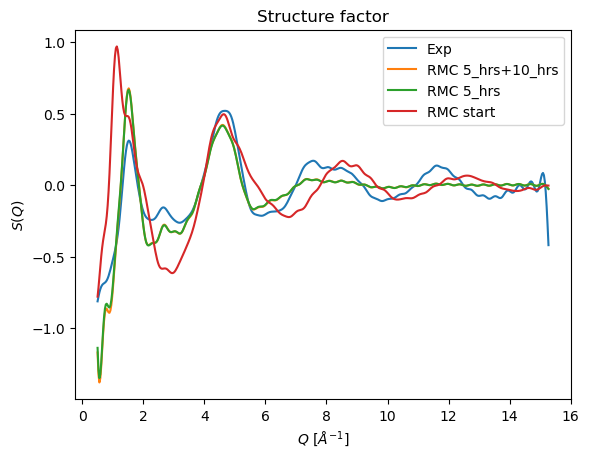

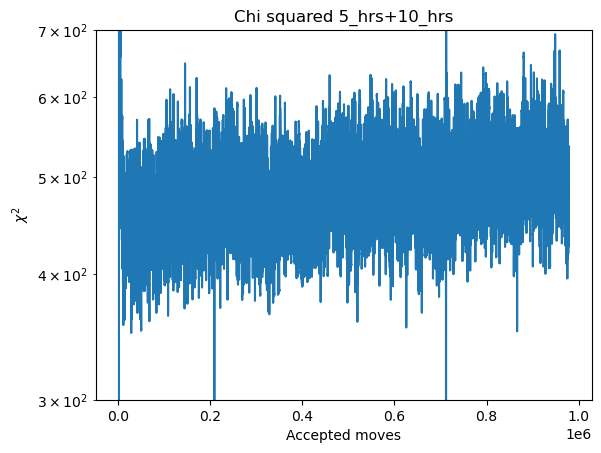

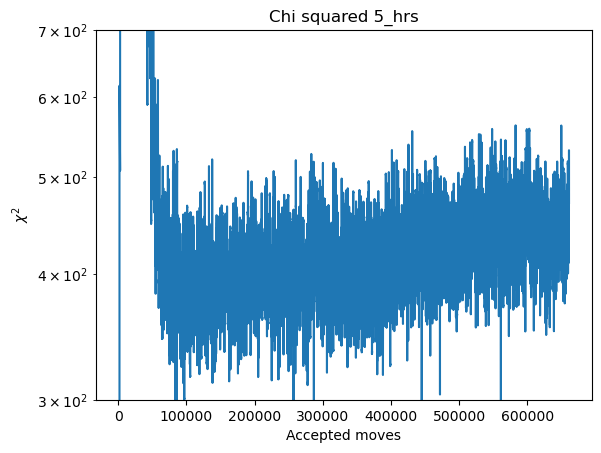

In [919]:
filepath = 'pbc_rulez_700/ge_o_network/coord'
directories = ['5_hrs+10_hrs','5_hrs','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[4,3e2,7e2])

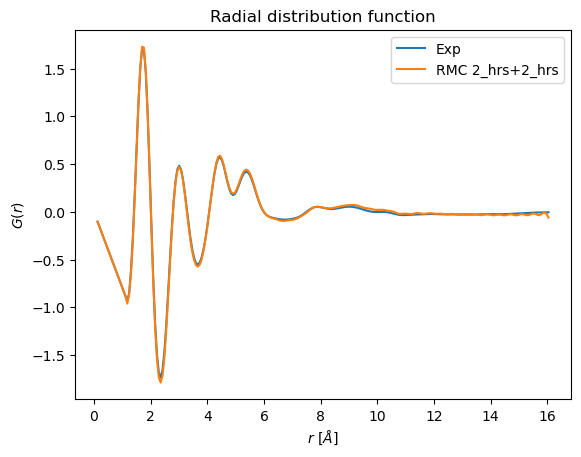

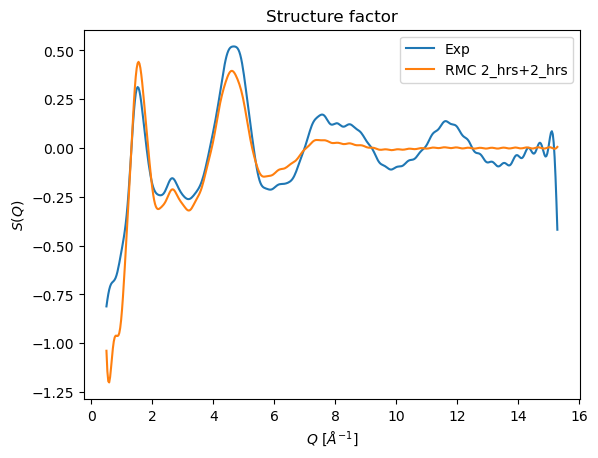

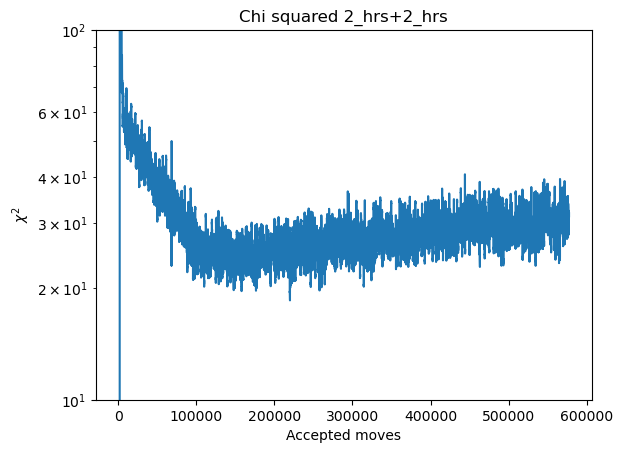

In [945]:
filepath = 'pbc_rulez_700/ge_o_network/no_constraints'
directories = ['2_hrs+2_hrs']#,'2_hrs']#,'start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'both',[4,1e1,1e2])

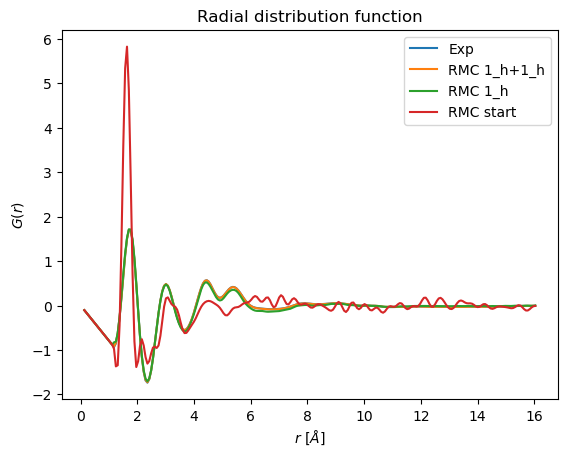

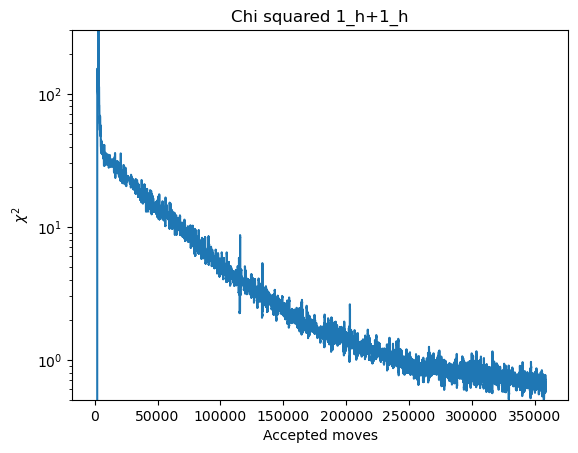

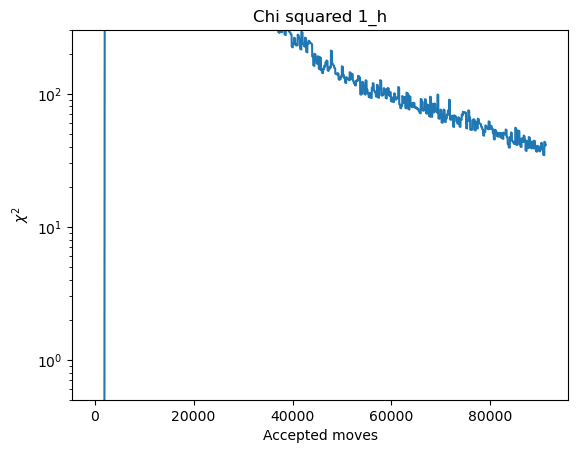

In [977]:
filepath = 'pbc_rulez_700/ge_o_network/no_constraints_gdr'
directories = ['1_h+1_h','1_h','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'gdr',[3,5e-1,3e2])

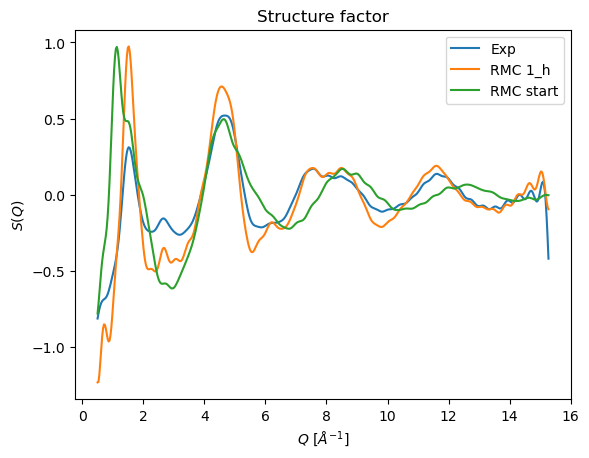

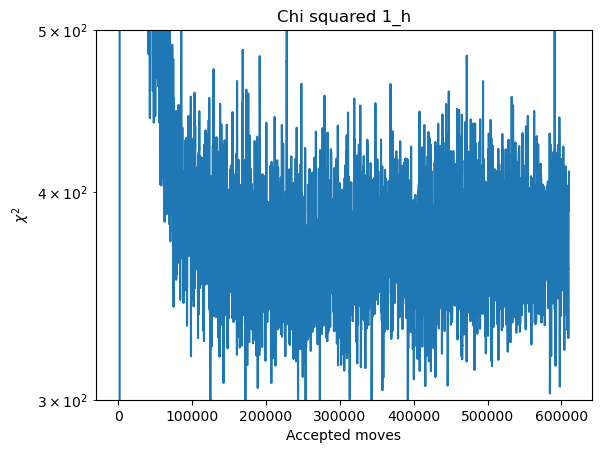

In [978]:
filepath = 'pbc_rulez_700/ge_o_network/no_constraints_sdq'
directories = ['1_h','start']
filename = 'ge_o_network'
check_RMC_simulation(filepath,directories,filename,'sdq',[3,3e2,5e2])

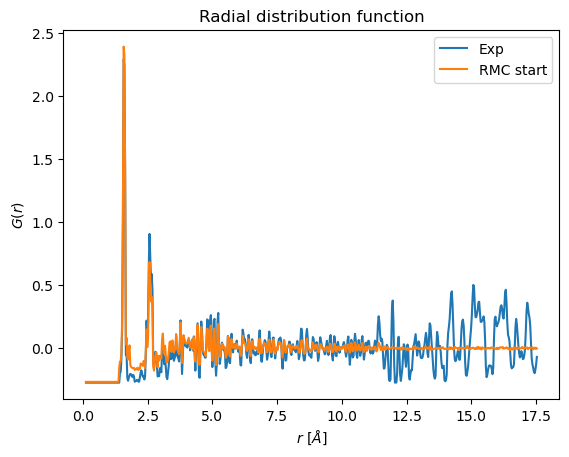

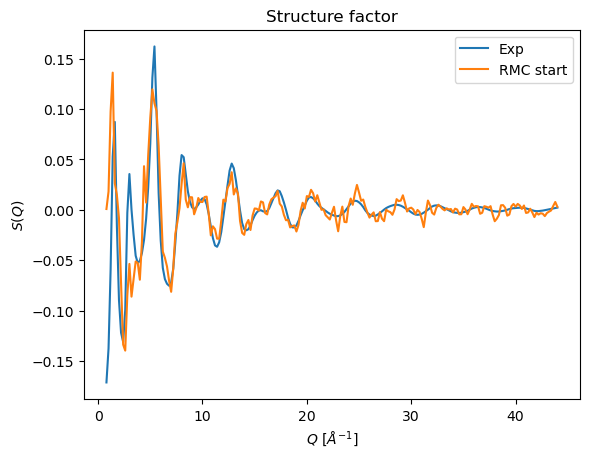

In [916]:
filepath = '../SiO2'
directories = ['final','8h_run','start']
filename = 'sio2'
check_RMC_simulation(filepath,directories,filename,'both',3)

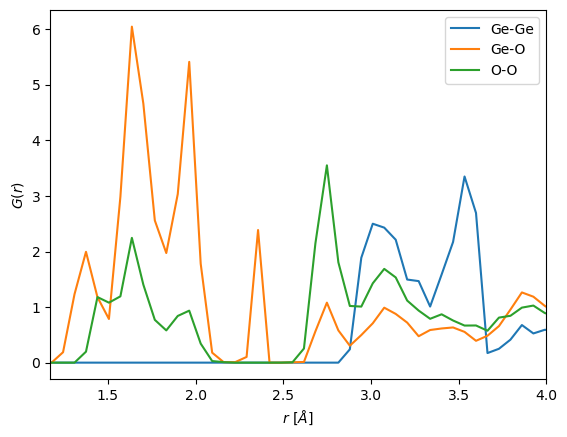

In [907]:
filepath = 'pbc_rulez_700/ge_o_network/dw/5_hrs+10_hrs/'

r = pd.read_csv(filepath+'ge_o_network_PDFpartials.csv',header=1,usecols = [0]).values.flatten()

gdr_GeGe = pd.read_csv(filepath+'ge_o_network_PDFpartials.csv',header=1,usecols = [1]).values.flatten()

gdr_GeO = pd.read_csv(filepath+'ge_o_network_PDFpartials.csv',header=1,usecols = [2]).values.flatten()

gdr_OO = pd.read_csv(filepath+'ge_o_network_PDFpartials.csv',header=1,usecols = [3]).values.flatten()


plt.plot(r,gdr_GeGe,label = 'Ge-Ge')
plt.plot(r,gdr_GeO, label = 'Ge-O')
plt.plot(r,gdr_OO, label = 'O-O')
plt.legend()
plt.xlabel(r'$r$ [$\AA$]')
plt.ylabel(r'$G(r)$')
plt.xlim(1.17,4)
plt.show()